# Assignment nº2
### Implementation and Analysis of Decision Tree Induction for Supervised Machine Learning
#### Work assembled by Alejandro Gonçalves, Francisca Mihalache and Pedro Fernandes

### Table of contents <a name="contents"></a>

1. [Introduction](#introduction)
2. [Datasets](#datasets)
   - 2.1. [Restaurant](#restaurant1)
   - 2.2. [Weather](#weather1)
   - 2.3. [Iris](#iris1)
   - 2.4. [Connect4](#connect41)
3. [ID3](#id3)
   - 3.1. [Entropy](#entropy)
   - 3.2. [Information Gain](#information_gain)
   - 3.3. [Example](#eg1)
4. [ID3 Implementation](#id3-implementation)
    - 4.1. [Restaurant](#restaurant2)
    - 4.2. [Weather](#weather2)
    - 4.3. [Iris](#iris2)
    - 4.4. [Connect4](#connect42)
5. [Conclusions](#conclusions)

## Introduction <a name="introduction"></a>
The goal is to implement the ID3 algorithm to learn decision trees from data, ensuring the program can both build the tree and classify new instances across different datasets, without using automatic libraries.

The focus is on learning the theoretical concepts and practically applying them to solve classification tasks effectively.

*The code can be ran sequentially. When pressing *run all*, if it gets stuck somewhere, re-running the cell individually will probably fix it.*

#### Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
from collections import Counter
from copy import deepcopy

## Datasets <a name="datasets"></a>
[[go back to the top]](#contents)

In this section, we will dive into the details of our datasets, exploring the nature of the data and the predictive outcomes they are associated with.

**Note**: for those with ID's, that column is dropped, since it has no predictive value.

### Restaurant <a name="restaurant1"></a>
[[go back to the topic]](#datasets)

This csv contains some examples of decision making. Given some information, the target is to decide whether the client waits or not.
Each line, each instance contains 12 attributes, split among these categories.

1. **Identification and Basic Information**:
   - ID: Personal identifier for each restaurant entry.
   - Type: Classification of the type of cuisine offered by the restaurant.

2. **Dining Options within the Restaurant**:
   - Alt: Availability of Alt dining options.
   - Bar: Presence of a bar within the restaurant premises.

3. **Temporal and Climate Conditions**:
   - Fri: Indication of whether it is Friday or not.
   - Rain: Weather condition, specifically rainy weather.

4. **Customer Attributes**:
   - Hun: Customer's hunger level.
   - Pat: Patron density, indicating how crowded the restaurant is.

5. **Service and Pricing**:
   - Price: Price range of the restaurant.
   - Res: Reservation availability for customers.

6. **Wait Time**:
   - Est: Estimated waiting time for a table.
  
7. **Decision Making**:
   - Class: Target variable indicating whether a customer decides to wait for a table ('Yes') or not ('No').


### Data Checking and cleanup

In [4]:
df1 = pd.read_csv('restaurant.csv')
df1.head()

,ID,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Class
0,X1,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,X2,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,X3,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,X4,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,X5,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No


#### Missing Values
Checking if there's any missing values.

In [5]:
print(df1.isnull().sum())

ID       0
Alt      0
Bar      0
Fri      0
Hun      0
Pat      0
Price    0
Rain     0
Res      0
Type     0
Est      0
Class    0
dtype: int64


#### Mapping Booleans to Integers

By replacing String values with small integers, it's easier for the program to process boolean values, and even the ones that have more than 2 options, for example the attribute **Price**.

After the last evaluation, we need to handle the empty (None) values in the Pat attribute. (None != 'None').

Again, if there is need to do so, just uncommenting what's below is enough.

In [6]:
'''
df1['Alt'] = df1['Alt'].replace({'No': '0', 'Yes': '1'})
df1['Bar'] = df1['Bar'].replace({'No': 0, 'Yes': 1})
df1['Fri'] = df1['Fri'].replace({'No': 0, 'Yes': 1})
df1['Hun'] = df1['Hun'].replace({'No': 0, 'Yes': 1})
df1['Rain'] = df1['Rain'].replace({'No': 0, 'Yes': 1})
df1['Res'] = df1['Res'].replace({'No': 0, 'Yes': 1})
df1['Class'] = df1['Class'].replace({'No': 0, 'Yes': 1})
df1['Type'] = df1['Type'].replace({'French':0, 'Thai':1, 'Burger':2, 'Italian':3})

'''
#df1['Est'] = df1['Est'].replace({'0-10': 0, '10-30': 1, '30-60': 2, '>60': 3})
#df1['Price'] = df1['Price'].replace({'$':0, '$$':1,'$$$':2})

# trivial python implementation to solve the labels with empty values
def map_pat_to_int(value):
    mapping = {'None': 'None', 'Some': 'Some', 'Full': 'Full'}
    return mapping.get(value, -1)  # return -1 for empty values

df1['Pat'] = df1['Pat'].apply(map_pat_to_int)
df1 = df1.drop('ID', axis=1)
df1.head()

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Class
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No


### Weather <a name="weather1"></a>
[[go back to the topic]](#datasets)

The 'weather' dataset holds a range of meteorological conditions and their impact on the decision to engage in an outdoor activity (specifically playing a sport).

1. **ID** - Unique instance identification
  
2. **Weather Conditions**
   - Weather: sunny, overcast, rainy
   - Temperature: temperature (F) value
   - Humidity: percentage, ranging from 0-100
   - Windy: presence or absence 

3. **Decision** - Play or not

### Data Cleanup

In [7]:
df2 = pd.read_csv('weather.csv')
df2 = df2.drop('ID', axis=1)
df2.head()

,Weather,Temp,Humidity,Windy,Play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes


#### Missing values
Checking if there's any missing values, if so, those need to be handled accordingly. (There are none)

In [8]:
print(df2.isnull().sum())

Weather     0
Temp        0
Humidity    0
Windy       0
Play        0
dtype: int64


### Iris <a name="iris1"></a>
[[go back to the topic]](#datasets)

The 'iris' dataset, which is renowned for its introdutory role in the ML world, records the morphological measurements of *Iris* flowers. The attributes recorded are the following: 

 1. **ID** - Unique instance identification
  
2. **Features**
   - Sepal Length
   - Petal Length
   - Sepal Width
   - Petal Width

3. **Decision** - Decide which species (Iris-setosa, Iris-versicolor, or Iris-virginica) the instance belongs to. 

In [9]:
df3 = pd.read_csv('iris.csv')
df3 = df3.drop('ID', axis=1)
df3.head(100)

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,Iris-versicolor
96,5.7,2.9,4.2,1.3,Iris-versicolor
97,6.2,2.9,4.3,1.3,Iris-versicolor
98,5.1,2.5,3.0,1.1,Iris-versicolor


#### Missing Values
Checking if there's any missing values, we conclude that there are none.

In [10]:
print(df3.isnull().sum())

sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64


#### Creating a **scatterplot matrix**
Although not used, it's useful to check this datasets data properties.


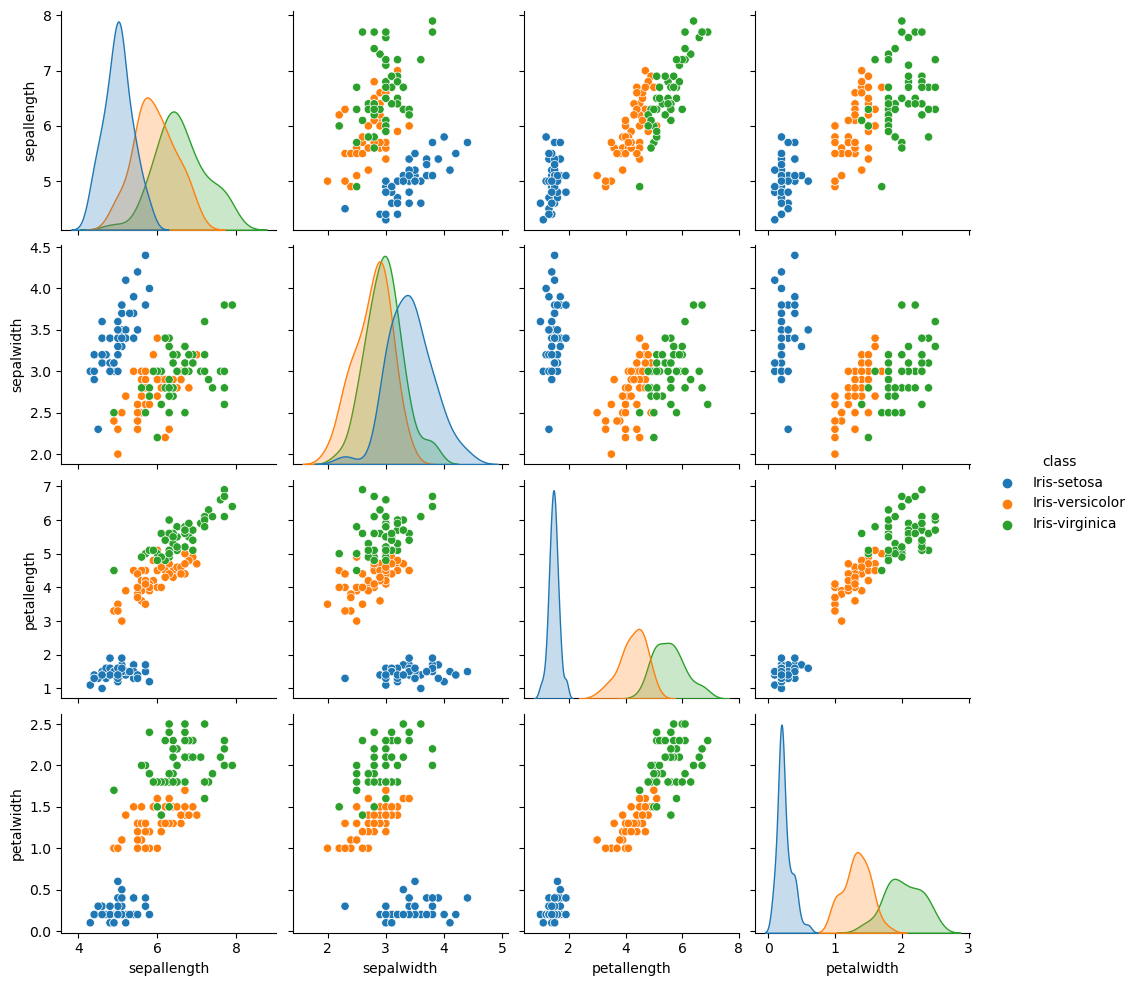

In [11]:
sb.pairplot(df3, hue='class')

**Note for the Iris dataset**: after careful search andevaluation, we concluded that the dataset is already clean, without outliers. For that reason, no further issues considering the csv will take place.

### Connect4 <a name="connect41"></a>
[[go back to the topic]](#datasets)

The 'connect4' csv consists of multiple instances representing endgame states of the Connect Four game. The objective is to use these configurations to predict the outcome of the game - whether it ends in a win for the first player, a win for the second player, or a draw. 

This dataset is different fundamentaly, it does not contain attributes, but only the final state and the winner.

In [12]:
df4 = pd.read_csv('connect4.csv',header=0) 

df4.head(10)

,b,b.1,b.2,b.3,b.4,b.5,b.6,b.7,b.8,b.9,...,b.25,b.26,b.27,b.28,b.29,b.30,b.31,b.32,b.33,win
0,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,o,b,b,b,...,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
3,o,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
4,b,b,b,b,b,b,b,b,b,b,...,b,b,b,o,b,b,b,b,b,win
5,b,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,draw
6,b,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,win
7,b,b,b,b,b,b,x,o,b,b,...,b,b,b,b,b,b,b,b,b,win
8,b,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,win
9,o,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,win


#### Missing Values
No missing values, so no need to access that problem.

In [13]:
#print(df4.isnull().sum())

## ID3 <a name="id3"></a>
[[go back to the top]](#contents)

A instance of the class ID3 will be defined only by the dataframe. Then, since all datasets are built the same, and all functions and the class logic keep on using the target (last column) and the attributes (excluding 1st and last), we define those in the *__init__*.

All methods will have a commentary below briefly describing each method. When placing the cursor on a function call, there is a small description that helps the orientation through the notebook.

In [14]:
class ID3:
    def __init__(self, df):
        '''Initializes the class, defines the target and attributes subset.'''
        self.df = df
        # self.tree = self._build_tree(df) # Pedro -> didn't work because of the order of definitions in the notebook I think, the idea was to, when defining the ID3 instance, creating the tree immediatly
        self.atts = df.columns.tolist()[0:-1] 
        self.target = df.columns.tolist()[-1] 

The ID3 decision tree algorithm strategically employs Information Gain to identify optimal points for splitting the data during the tree-building process. This selection is crucial as it influences the algorithm's ability to accurately classify data.

 To quantify IG, he uses the concept of **Entropy**. By calculating Entropy, we can evaluate the effectiveness of each potential split in **reducing uncertainty**, guiding the decision tree to more effective and informed splits that **enhance classification performance**.

### Initial Entropy Calculation:
- **Definition of Entropy:** Measures the amount of uncertainty in the dataset.
- **Entropy Calculation Formula:**

  $$ 
  \text{Entropy}(S) = -\sum_{i=1}^n p_i \log_2(p_i) 
  $$
  - **n:** Total number of classes in the target column.
  - **p_i:** Probability of class i, or the ratio of "number of rows with class i in the target column" to the "total number of rows" in the dataset.
  - **log_2(p_i):** Logarithm base 2 of p_i, used to calculate the entropy contribution of each class.


#### Information Gain Assessment:
- **Information Gain Calculation:** Determine the gain in information by computing the change in entropy before and after partitioning the dataset based on an attribute.

  - **Information Gain Formula:**
    $$
    IG(S, A) = \text{Entropy}(S)- \sum \left( \frac{|S_v|}{|S|} \cdot \text{Entropy}(S_v) \right)
  $$
    
  In this formula:
  - **S**  is the entire dataset.
  - **A** is the attribute used for partitioning.
  - **S_v**  is the size of the subset of S where the attribute A has value v.
  - **|S|**  is the total size of the dataset.
  - **Entropy(S)** is the entropy of the entire dataset S.
  - **Entropy(S_v)** is the entropy of subset S_v. 

##### Attribute Selection:
- **Optimal Attribute Choice:** Select the attribute with the maximal information gain for splitting. This is done by calculating the information gain for each attribute and comparing these values to identify the attribute that most effectively reduces uncertainty.

##### Iterative Process:
- **Repetition Until Completion:** Continuing the process iteratively, applying the steps of entropy calculation, information gain assessment, and attribute selection recursively on each subset of the dataset created by a decision node.

- The process ends when all data at a node have the same class, no remaining attributes exist for further partitioning, or another stopping criterion is met.

### Calculating the Entropy <a name="entropy"></a>
[[go back to the topic]](#id3)

In order to do so, here's an implementation in python which calculates the entropy given the different values parsed as a function. 

In [15]:
class ID3(ID3):
    def _entropy(self, class_counts):
        """Return the entropy given a list with the class counts."""
        total = sum(class_counts) 
        if total == 0:
            return 0 

        entropy = 0
        for count in class_counts:
            if count > 0:
                probability = count / total
                entropy -= probability * math.log2(probability)
        #print(class_counts)
        return entropy


class_counts = [25, 25]
a = ID3(df1)  
entropy = a._entropy(class_counts)
print(f"Entropy of the distribution is: {entropy}")


Entropy of the distribution is: 1.0


Now we need to parse all the class counts as a list, and compare the different entropies, to choose the one that properly divides the dataset the most.


### Calculating the Information Gain <a name="information_gain"></a>
[[go back to the topic]](#id3)

Now, using the previous function, we need to calculate the information gain for splitting the tree using the attribute_name, and the target_name.

Next, there is an implementation in *python* which calculates the IG given the previously stated arguments.

The function starts by calculating the weighted entropy, doing the summatory described above, and then doing the formula below.

In [16]:
class ID3(ID3):
    def _calculate_entropy_of_split(self, df, target_attribute):
        '''Auxiliar to _information_gain, parses the target att counts to entropy'''
        counts = [len(df[df[target_attribute] == value]) for value in df[target_attribute].unique()]
        return self._entropy(counts)

    def _information_gain(self, df_subset, attribute_name):
        '''Returns IG given the current subset and the attribute'''
        total_entropy = self._calculate_entropy_of_split(df_subset, self.target)
        weighted_entropy = 0

        for value in df_subset[attribute_name].unique(): # for each unique value in the df_subset attribute
            subset = df_subset[df_subset[attribute_name] == value] # 
            subset_entropy = self._calculate_entropy_of_split(subset, self.target)
            weighted_entropy += (len(subset) / len(df_subset)) * subset_entropy

        return total_entropy - weighted_entropy

#### Plurality Values

According to page 660 of the manual, **if** there is need to break ties, we pick the **most common output value** among a set of examples.

Panda module has a built-in function to order by the most common, so we just need to adapt it. Although not now, it might be used for later.

In [17]:
class ID3(ID3):
    def _plurality_value(self, target_attribute):
        """Return the most common value in the target attribute."""
        return Counter(self.df[target_attribute]).most_common(1)[0][0]

#### Example <a name="eg1"></a>
[[go back to the topic]](#id3)

Let's test the new function for the Restaurant csv, splitting on the **Alt** attribute.


In [18]:
column_name = 'Alt'

unique_values = df1[column_name].unique()

class_counts = []
for arr in unique_values:
    x = df1[df1[column_name] == arr].shape[0]
    class_counts.append(x)

print(class_counts)

[6, 6]


Now we are good to go.
The entropy should be 1, as it splits the dataset evenly, but we will test the function now.

Then, we can test the IG calculation.

In [19]:
b = ID3(df1)
entr = b._entropy(class_counts)
print(f"Entropy for {class_counts} : {entr}")

Entropy for [6, 6] : 1.0


In [20]:
c = ID3(df1)

information_gains = {}

for column in c.atts:
    gain = c._information_gain(c.df, column)
    information_gains[column] = gain

# Choose the attribute with the highest information gain
max_gain_attr = max(information_gains, key=information_gains.get)

print(f"\nAttribute with the maximum information gain: {max_gain_attr} (IG: {information_gains[max_gain_attr]:.3f})")


Attribute with the maximum information gain: Pat (IG: 0.541)


The IG associated with each attribute is represented in the table below, in which we can assess that in fact, Pat has the highest IG score.



| **Attribute**  | Alt | Bar | Fri | Hun | Pat | Price | Rain | Res | Type | Est |
|------------|-----|-----|-----|-----|-----|-------|------|-----|------|-----|
| **Information Gain**  | 0.000 | 0.000 | 0.021 | 0.196 | 0.541 | 0.196 | 0.000 | 0.021 | 0.000 | 0.208 |



Now we have the base working for the ID3 algorithm, and can calculate the IG of the attributes correctly in each instance.

#### Choose the best attribute

In order to do so, we just need to use the previously defined methods, to pick the index of the attribute with the highest IG. 

The ID3 method *choose_best_attribute* creates a dictionary that links all the (remaining) attributes to their respective IG, and returns the key (attribute name) of the one with the max IG.

In [21]:
class ID3(ID3):
    def choose_best_attribute(self, df_subset):    
        """Returns, given the subset, the name of the attribute with the highest IG."""    
        remaining_attributes = [col for col in df_subset.columns if col != self.target] # debug/double-checking step

        information_gains = {} # dict att -> IG(att)
        for attr in remaining_attributes:
            information_gains[attr] = self._information_gain(df_subset, attr)

        return max(information_gains, key=information_gains.get)

d = ID3(df1)
subset = d.df  # simulating the first iteration, therefore we use the entire dataset
best_attribute = d.choose_best_attribute(subset)

print("Best Attribute for Splitting:", best_attribute)

Best Attribute for Splitting: Pat


## ID3 Implementation <a name="id3-implementation"></a> 
[[go back to the top]](#contents)

### Restaurant Implementation <a name="restaurant2"></a> 

This is the simplest one. No adaptations are required, since the **values are discrete**, and not continuous values, and the **target class is binary**.

In [22]:
class ID3(ID3):
    def _build_tree(self, data):
        """Constructs the nested dictionary for a specific dataframe, has the argument data for the recursion matter."""
        # debug statements from chatGPT

        labels = data[data.columns[-1]].tolist()
        class_counts = Counter(labels)

        # Base cases
        if len(set(labels)) == 1:
            return [labels[0], class_counts[labels[0]]]  # returned 2 thing to help the debug below
        if len(data.columns) == 1:
            return [class_counts.most_common(1)[0][0], len(labels)] 

        # Choose the best attribute to split on
        best_attribute = self.choose_best_attribute(data)
        node = {best_attribute: {}}

        complete_values = self.df[best_attribute].unique() # since French was missing, we need another "flag"
        subset_values = data[best_attribute].unique()
        # print(f"Building tree on {best_attribute}, values: {complete_values}")
        
        # missing_values = set(complete_values) - set(subset_values)
        # print(missing_values)

        for value in complete_values:
            subset = data[data[best_attribute] == value]
            if subset.empty:
                # Assign the majority class if this value is missing in the subset
                majority_class = class_counts.most_common(1)[0][0]
                # print(f"Value '{value}' missing. Assigning majority class '{majority_class}'")
                node[best_attribute][value] = [majority_class, 0]
            else:
                # Recursively build the tree for non-empty subsets
                remaining_data = subset.drop(columns=[best_attribute])
                node[best_attribute][value] = self._build_tree(remaining_data)

        return node

In [23]:
# test the function usage 
e = ID3(df1)
decision_tree_structure = e._build_tree(e.df)

print(decision_tree_structure)

{'Pat': {'Some': ['Yes', 4], 'Full': {'Hun': {'Yes': {'Type': {'French': ['No', 0], 'Thai': {'Fri': {'No': ['No', 1], 'Yes': ['Yes', 1]}}, 'Burger': ['Yes', 1], 'Italian': ['No', 1]}}, 'No': ['No', 2]}}, 'None': ['No', 2]}}


We can however define a recursive function with the corresponding indents, and make it look more like a tree. Since the formattation is not relevant to the project's objective, we used chatGPT to define the *_recursive_print_tree* method.

In [24]:
class ID3(ID3):
    def print_tree(self, tree_structure):
        """Public method to print the tree. Needed to solve the issue with the arguments and recursions."""
        print("{")
        self._recursive_print_tree(tree_structure, "      ")
        print("}")

    def _recursive_print_tree(self, tree, prefix="", indent="      "):
        """Private method that prints the nested dictionary as a tree, recursively. The indent is increasable for aesthetic reasons."""
        if isinstance(tree, dict):
            for attribute, branches in tree.items():
                print(prefix + f"'{attribute}': {{")
                last_value = len(branches) - 1

                for index, (value, subtree) in enumerate(branches.items()):
                    is_last = index == last_value
                    value_prefix = prefix + indent

                    if isinstance(subtree, dict):
                        print(value_prefix + f"'{value}': {{")
                        self._recursive_print_tree(subtree, value_prefix + indent, indent)
                        print(value_prefix + "}" + ("," if not is_last else ""))
                    else:
                        # Leaf node handling
                        leaf_value = subtree[0] if isinstance(subtree, list) else subtree
                        print(value_prefix + f"'{value}': '{leaf_value}'" + ("," if not is_last else ""))

                print(prefix + "}" + ("," if not is_last else ""))

        else:
            # Handle single-value leaf nodes
            leaf_value = tree[0] if isinstance(tree, list) else tree
            print(prefix + f"'{leaf_value}'")


In [25]:
final1 = ID3(df1)
tree1 = final1._build_tree(final1.df)
final1.print_tree(tree1)

{
      'Pat': {
            'Some': 'Yes',
            'Full': {
                  'Hun': {
                        'Yes': {
                              'Type': {
                                    'French': 'No',
                                    'Thai': {
                                          'Fri': {
                                                'No': 'No',
                                                'Yes': 'Yes'
                                          }
                                    },
                                    'Burger': 'Yes',
                                    'Italian': 'No'
                              }
                        },
                        'No': 'No'
                  }
            },
            'None': 'No'
      }
}


#### Classify examples for Restaurant

We can create a new function, that iterates recursively the nested dictionary in order to classify a new example.

In [26]:
class ID3(ID3):
    def classify(self, instance, node=None): # Classify a new instance using the decision tree.
        '''Given an instance defined in a dictionary, iterates through the dictionary to classify new examples.'''
        if not isinstance(node, dict):
            return node  # Leaf node with classification label
        attribute = next(iter(node))
        value = instance.get(attribute)
        next_branch = node.get(attribute).get(value, 'Unknown')
        if isinstance(next_branch, dict):
            return self.classify(instance, next_branch) # Iterate recursively to the next branch
        else:
            return next_branch

Below we can define a new instance, and given the generated tree, will take the proper decision.

In [27]:
new_instance = {
    'Alt': 'Yes',
    'Bar': 'No',
    'Fri': 'Yes',
    'Hun': 'No',
    'Pat': 'Some',
    'Price': '$$$',
    'Rain': 'No',
    'Res': 'Yes',
    'Type': 'Italian',
    'Est': '10-30'
}

f = ID3(df1)
pred1 = f.classify(new_instance, decision_tree_structure)[0]
print("Do them wait for a table?:", pred1)

Do them wait for a table?: Yes


#### Classify Bonus for Restaurant
By reading the manual *(page 658, Figure 19.3)*, we realized **there is a complete tree for this decision**, and the tree we conducted is constructed following a short list of examples.

We can evaluate the tree generated based on examples that follow the "real/complete" DT.

The procedure is simply to **generate a finite number of instances** that follow that DT assignment, and give a score based on that, using the *classify()*, and comparing the expected result.

#### 1) Complete Tree representation:

In [28]:
decision_tree_real = {
    "Pat": {
        "None": "No",
        "Some": "Yes",
        "Full": {
            "Est": {
                "0-10": "Yes",
                "10-30": {
                    "Hun?": {
                        "Yes": {
                            "Alt": {
                                "No": "Yes",
                                "Yes": {
                                    "Rain": {
                                        "No": "No",
                                        "Yes": "Yes"
                                    }
                                }
                            }
                        },
                        "No": "Yes"
                    }
                },
                "30-60": {
                    "Alt": {
                        "Yes": {
                            "Fri": {
                                "Yes": "Yes",
                                "No": "No"
                            }
                        },
                        "No": {
                            "Res": {
                                "Yes": "Yes",
                                "No": {
                                    "Bar": {
                                        "Yes": "Yes",
                                        "No": "No"
                                    }
                                }
                            }
                        }
                    }
                },
                ">60": "No"
            }
        }
    }
}

import random

def create_new_rand_instance_rest(): 
    """Returns a dictionary correspondent to a random assignment of attributes."""
    l1 = ['Yes', 'No']
    l2 = ['None', 'Some', 'Full']
    l3 = ['$', '$$', '$$$']
    l4 = ['French', 'Thai', 'Italian', 'Burger']
    l5 = ['0-10', '10-30', '30-60', '>60']

    ret_dict = {
        'Alt': random.choice(l1),
        'Bar': random.choice(l1),
        'Fri': random.choice(l1),
        'Hun': random.choice(l1),
        'Pat': random.choice(l2),
        'Price': random.choice(l3),
        'Rain': random.choice(l1),
        'Res': random.choice(l1),
        'Type': random.choice(l4),
        'Est': random.choice(l5),
    }

    return ret_dict

def normalize_response(response): # we were having issues, this is a trivial way to solve all formattation related problems
    if 'Y' in str(response):
        return 'Yes'
    elif 'N' in str(response):
        return 'No'
    return response  

def simulation_restaurant(total_simul):
    inst_temp = ID3(df1)
    csv_dt = inst_temp._build_tree(inst_temp.df)
    real_dt = decision_tree_real

    count_same = 0
    for _ in range(total_simul):
        x = create_new_rand_instance_rest()
        cl1 = inst_temp.classify(x, csv_dt) # alusive to out generated tree
        cl2 = inst_temp.classify(x, real_dt)

        # print(normalize_response(cl1) + ' ' + normalize_response(cl2))
        if normalize_response(cl1)==normalize_response(cl2):
            count_same += 1
    
    return (count_same/total_simul)*100

print(f"The simulations calculate the generated tree to classify correctly {round(simulation_restaurant(10000))}% of the cases.")

The simulations calculate the generated tree to classify correctly 79% of the cases.


### Weather Implementation <a name="weather2"></a> 
[[go back to the topic]](#id3-implementation)

Now, instead of only having discrete values, they are now continuous, in the attributes **Temperature** and **Humidity**. In order to handle them, different rules must be written: instead of **choosing according to the value** we need to **find the best split value**, meaning the value in which the function splits the best.

What this means is, instead of the only operator being "=" (eg: if 'Pat' = 'Some'), now there is <= and >, for example, if **Temperature<80**.

*This notebook will be overwriting the ID3 class functions during the generalization process.*

#### Best split value

There are several ways to choose the value to which we divide the class. For example, we can divide considering the **half of the interval range a-b**:

$$
\text{α} = \frac{{a + b}}{2}
$$

Another way is to use the value α such that the number of elements above and below it are equal.
$$
\exists y \text{ : } \text{count}(X \geq α) \approx \text{count}(X \leq α)
$$

During this project we decided to **brute-force all possible values** already existing on that attribute, and choose the value α, that works on the highest information gain. To do so, we need to get all the values, divide into subsets and see which "splitter" works on the best IG.

The approach was simple, in a copy, replace all the values above or below the split_value explicitly, and then parse those to the previous IG function. Although not optimal, the usage of *deepcopy* made easier for the project comprehension. 

To check if the replacement is produced properly, *uncomment all the code on the auxiliar function and run the next 2 code cells*.

In [29]:
import copy

class ID3(ID3):
    def _calculate_best_split_value_aux(self, df_subset, att, split_value):
        '''Auxiliar method, given a df_subset, a numerical attribute and the split value, it replaces the values (makes them discrete), and proceeds to calculate the IG as usual.'''
        df_copy = copy.deepcopy(df_subset)

        print_once_bool = False # lazy way to not print the head of the df a lot of times, prints only once since subset gets shorter
        if df_subset.equals(self.df):
            print_once_bool = True

        for index in df_copy.index:
            if df_copy.loc[index, att] <= split_value:
                df_copy.loc[index, att] = 'leq'
            else:
                df_copy.loc[index, att] = 'more'
        '''
        if (print_once_bool): # print only once, in the first iteration
            print(split_value)
            print(self.df.head(10))
            print("\n")
            print(df_copy.head(10)) 
            print("\n---------------------------------------------------------------\n")
        '''
        return self._information_gain(df_copy, att)
        
        
    def _calculate_best_split_value(self, df_subset, att):
        '''Given a subset, and a numerical attribute, returns a tuple with the best split value, and the respective IG when it splits the dataset there.'''
        unique_values = sorted(df_subset[att].unique()) # list with the sorted unique values
        #print(unique_values) 
        best_split_value = None
        best_ig = float('-inf')

        for i in range(1, len(unique_values)):
            #split_value = (unique_values[i]) 
            split_value = (unique_values[i-1] + unique_values[i]) / 2 # if we want the midpoint
            ig = self._calculate_best_split_value_aux(df_subset, att, split_value)

            #print(f"Current best value: {best_split_value} (IG: {best_ig}), testing for {split_value}... obtained IG:{ig}")
            if ig > best_ig:
                best_ig = ig
                best_split_value = split_value

        return best_split_value, best_ig

We can test the function, creating a instance for the weather.csv dataframe and testing on the **Temp** attribute.

In [30]:
test = ID3(df2)
test._calculate_best_split_value(test.df, 'Temp')

(84.0, 0.1134008641811034)

#### Adaptations for the code to run on the Weather dataframe

Using this new implemented logic, some changes are required:
- the *_choose_best_atribute* should be changed, and perform the conversion of the column to parse it to the IG function properly;
- the *_build_tree* method needs to be able to check the type of data, and:
   - if **categorical**, proceeds normally to get the IG;
   - if **numerical**, needs to get the IG by testing all the different split values.;
- the *_print_tree* associated method needs to print with the operators formatted as well, this method doesn't need to be changed, but the *_build_tree* needs to set the keys of the dictionary already with the operators.

We can test the new adapted function along the way:
 

In [31]:
class ID3(ID3):
    def _choose_best_attribute(self, df_subset):        
        """Returns, given the subset, the name of the attribute with the highest IG."""    
        remaining_attributes = [col for col in df_subset.columns if col != self.target] # debug step

        information_gains = {} # dict att -> IG(att)

        for attr in remaining_attributes:
            if df_subset[attr].dtype in ['int64', 'float64']:
                #print(attr + ', value of the split: ' + str(self._calculate_best_split_value(df_subset, attr)[0]) + ' , IG of the split: ' + str(self._calculate_best_split_value(df_subset, attr)[1]))
                information_gains[attr] = self._calculate_best_split_value(df_subset, attr)[1] # reminder that this method returns tuple(value, ig)
            else:
                information_gains[attr] =  self._information_gain(df_subset, attr)
                #print(attr + ' with IG : ' + str(self._information_gain(df_subset, attr)))

        return max(information_gains, key=information_gains.get)
        # return best_attribute


We can create an instance for both **df1** and **df2**, and check if it's still all working properly.

In [32]:
df1_inst = ID3(df1)
df2_inst = ID3(df2)

#print(df1_inst.choose_best_attribute(df1_inst.df))
#print(df2_inst.target)
print(f"The attribute with the highest IG is: {df2_inst._choose_best_attribute(df2_inst.df)}.")

The attribute with the highest IG is: Weather.


In [33]:
class ID3(ID3):
    def _build_tree(self, data):
        """Constructs the nested dictionary for a specific dataframe, has the argument data for the recursion matter."""
        labels = data[data.columns[-1]].tolist()
        class_counts = Counter(labels)

        # Base cases
        if len(set(labels)) == 1:
            return [labels[0], class_counts[labels[0]]]
        if len(data.columns) == 1:
            return [class_counts.most_common(1)[0][0], len(labels)]

        # Choose the best attribute to split on
        best_attribute = self._choose_best_attribute(data)
        node = {best_attribute: {}}

        # case 1 - continuous attributes separately
        if data[best_attribute].dtype in ['int64', 'float64']:
            best_split_value = self._calculate_best_split_value(data, best_attribute)[0] # since _calculate_best_split_value returns a tuple
            subset1 = data[data[best_attribute] <= best_split_value]
            subset2 = data[data[best_attribute] > best_split_value]
            node[best_attribute]['<= ' + str(best_split_value)] = self._build_tree(subset1)
            node[best_attribute]['> ' + str(best_split_value)] = self._build_tree(subset2)

        # case 2 - discrete attributes, previous logic
        else:
            complete_values = self.df[best_attribute].unique()
            for value in complete_values:
                subset = data[data[best_attribute] == value]

                if subset.empty:
                    # Assign the majority class if the value is missing
                    majority_class = class_counts.most_common(1)[0][0]
                    node[best_attribute][value] = [majority_class, 0]
                else:
                    remaining_data = subset.drop(columns=[best_attribute])
                    node[best_attribute][value] = self._build_tree(remaining_data)

        return node


Given the updates, we can build the tree, using the same print_tree function as before.

In [34]:
teste2 = ID3(df2)
decision_tree_structure2 = teste2._build_tree(teste2.df)
teste2.print_tree(decision_tree_structure2)

{
      'Weather': {
            'sunny': {
                  'Humidity': {
                        '<= 77.5': 'yes',
                        '> 77.5': 'no'
                  }
            },
            'overcast': 'yes',
            'rainy': {
                  'Windy': {
                        'False': 'yes',
                        'True': 'no'
                  }
            }
      }
}


To classify new examples, we need to adapt the *_classify* method to handle continuous values. 

In [35]:
class ID3(ID3):
    def classify(self, instance, node=None):
        '''Given an instance defined in a dictionary, iterates through the dictionary to classify new examples.'''
        if not isinstance(node, dict):
            return node[0]  # return the classification label

        attribute = next(iter(node)) 
        if attribute in instance:  
            attribute_value = instance[attribute] 

            # check for continuous or discrete attribute handling, and check operator within the key
            if isinstance(attribute_value, (int, float)):  
                for key in node[attribute]:
                    if "<=" in key:
                        split_value = float(key.split('<= ')[1])
                        if attribute_value <= split_value:
                            return self.classify(instance, node[attribute][key])
                    elif ">" in key:
                        split_value = float(key.split('> ')[1])
                        if attribute_value > split_value:
                            return self.classify(instance, node[attribute][key])
            else: # discrete, same logic as before
                next_branch = node[attribute].get(attribute_value, 'Unknown')
                if isinstance(next_branch, dict):
                    return self.classify(instance, next_branch)  
                else:
                    # Correct handling of leaf nodes when not a dictionary
                    return next_branch[0] if next_branch != 'Unknown' else 'Unknown'

        return 'Unknown'  


In [36]:
new_instance_2 = {
    'Weather': 'sunny',
    'Temp': 80,
    'Humidity': 90,
    'Windy': 'true'
}

y = ID3(df2)  # Ensure that y.tree is properly initialized with the decision tree
classification_result = y.classify(new_instance_2, decision_tree_structure2)
print("Does he/she play with those conditions?:", classification_result)


Does he/she play with those conditions?: no


### Iris Implementation <a name="iris2"></a> 
[[go back to the topic]](#id3-implementation)

The key difference between this dataset and the previous 2 is that the **target class is non binary** (3 species). Although ID3 is essentially a binary classifier, we can extend and its logic to go around this problem.

The simple application of what we had before, up until now results in the following tree:


In [37]:
teste3 = ID3(df3)
decision_tree_structure3 = teste3._build_tree(teste3.df)
teste3.print_tree(decision_tree_structure3)

{
      'petallength': {
            '<= 2.45': 'Iris-setosa',
            '> 2.45': {
                  'petalwidth': {
                        '<= 1.75': {
                              'petallength': {
                                    '<= 4.95': {
                                          'petalwidth': {
                                                '<= 1.65': 'Iris-versicolor',
                                                '> 1.65': 'Iris-virginica'
                                          }
                                    },
                                    '> 4.95': {
                                          'petalwidth': {
                                                '<= 1.55': 'Iris-virginica',
                                                '> 1.55': {
                                                      'sepallength': {
                                                            '<= 6.95': 'Iris-versicolor',
                                                

Although the tree is generated in some sense, it is wrong, since the code is made for binary targets.
The methodology we'll perform first is to adapt the code for ONE *vs* ALL trees.

Meaning we added a change to make it work and "callable":
- Essencially, we will create 3 copies of the dataframe df3, each one for each possible species target;
- then we will replace explicitly the target column values
  - let's assume the target is *'Iris-Setosa'*
  - the copy of the dataframe will replace the other 2 species with the same name, eg.: 'not-Iris-Setosa'
  - the tree generated will then have a binary target.

In [38]:
df3_setosa = deepcopy(df3)
df3_versicolor = deepcopy(df3)
df3_virginica = deepcopy(df3)

# make the target binary, in a 1v2 way
df3_setosa['class'] = df3_setosa['class'].where(df3_setosa['class'] == 'Iris-setosa', 'Not-Iris-Setosa')
df3_versicolor['class'] = df3_versicolor['class'].where(df3_versicolor['class'] == 'Iris-versicolor', 'Not-Iris-versicolor')
df3_virginica['class'] = df3_virginica['class'].where(df3_virginica['class'] == 'Iris-virginica', 'Not-Iris-virginica')

# create instances for each 
inst_setosa = ID3(df3_setosa)
inst_versicolor = ID3(df3_versicolor)
inst_virginica = ID3(df3_virginica)

# create dt structures
tree3_1 = inst_setosa._build_tree(inst_setosa.df)
tree3_2 = inst_versicolor._build_tree(inst_versicolor.df)
tree3_3 = inst_virginica._build_tree(inst_virginica.df)

In [39]:
# print the trees
print("Iris setosa tree: ")
inst_setosa.print_tree(tree3_1)
print("\n------------------------------------------------------\n")
print("Iris versicolor tree: ")
inst_versicolor.print_tree(tree3_2)
print("\n------------------------------------------------------\n")
print("Iris virginica tree: ")
inst_virginica.print_tree(tree3_3)

Iris setosa tree: 
{
      'petallength': {
            '<= 2.45': 'Iris-setosa',
            '> 2.45': 'Not-Iris-Setosa'
      }
}

------------------------------------------------------

Iris versicolor tree: 
{
      'petallength': {
            '<= 2.45': 'Not-Iris-versicolor',
            '> 2.45': {
                  'petalwidth': {
                        '<= 1.75': {
                              'petallength': {
                                    '<= 4.95': {
                                          'petalwidth': {
                                                '<= 1.65': 'Iris-versicolor',
                                                '> 1.65': 'Not-Iris-versicolor'
                                          }
                                    },
                                    '> 4.95': {
                                          'petalwidth': {
                                                '<= 1.55': 'Not-Iris-versicolor',
                                       

To test the new instances, we can use the function, to test a new instance with the instances represented in the dictionary as previously.

In [40]:
new_instance_3 = {
    'sepallength': 4.8,
    'sepalwidth': 3.1,
    'petallength': 1.6,
    'petalwidth': 0.2
}

z = ID3(df3)  # Ensure that y.tree is properly initialized with the decision tree
classification_result_setosa = inst_setosa.classify(new_instance_3, tree3_1)
res = 'Yes' if classification_result_setosa == 'Iris-setosa' else 'No'
print("Is the instance a Iris-setosa?:", res)

Is the instance a Iris-setosa?: Yes


We can also try to use all the datasets, and try to return an **answer that is coherent with all the trees**. Meaning the input can/will be accepted only when it is in accordance with the 3 trees.

This will be achieved in the following script.

In [41]:
# the 3 tree structures are stored in tree3_1, tree3_2, tree3_3

'''
# code above as a reminder
inst_setosa = ID3(df3_setosa)
inst_versicolor = ID3(df3_versicolor)
inst_virginica = ID3(df3_virginica)
'''

new_instance_3 = {
    'sepallength': 4.8,
    'sepalwidth': 3.1,
    'petallength': 1.6,
    'petalwidth': 0.2
}

# booleans definition
isSetosa = False
isVersicolor = False
isVirginica = False

for specie in ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']:
    if 'setosa' in specie:
        classification_result_setosa = inst_setosa.classify(new_instance_3, tree3_1)
        print('1->', classification_result_setosa)
        isSetosa = True if classification_result_setosa == 'Iris-setosa' else False
    if 'versicolor' in specie:
        classification_result_versicolor = inst_versicolor.classify(new_instance_3, tree3_2)
        print('2->', classification_result_versicolor)
        isVersicolor = True if classification_result_versicolor == 'Iris-versicolor' else False
    if 'virginica' in specie:
        classification_result_virginica = inst_virginica.classify(new_instance_3, tree3_3)
        print('3->', classification_result_virginica)
        isVirginica = True if classification_result_virginica == 'Iris-virginica' else False

num_trues = sum(x for x in [isSetosa, isVersicolor, isVirginica]) # sum of true values

if num_trues == 1:
    print("\nValid classification.")
else:
    print("\nInvalid classification.")


1-> Iris-setosa
2-> Not-Iris-versicolor
3-> Not-Iris-virginica

Valid classification.



#### Iris bonus test-split

To double-check and evaluate the performance of those trees, is (since the dataset is bigger than previously) to **perform a train/test split**, to evaluate the accuracy of the decision tree created.

The train_test split will be performed manually, without the use of *sklearn* module.

In [42]:
class ID3(ID3):
    def _score(self, test_split_frac=0.5, random_seed=42):
        """Calculate and return the accuracy of the decision tree for Iris."""

        random.seed(random_seed)

        df_shuffled = self.df.sample(random_state=random_seed).reset_index(drop=True)
        indexes = self.df.index.tolist()
        random.shuffle(indexes)
        df_shuffled = self.df.loc[indexes].reset_index(drop=True)

        # split the data, find the index using the fraction arg
        split_index = int(len(df_shuffled) * (1 - test_split_frac))
        train_data = df_shuffled[:split_index]
        test_data = df_shuffled[split_index:]   

        tree = self._build_tree(train_data) # tree build on the training data

        # evaluate accuracy on the testing set, using same approach as 1.
        correct_predictions = 0
        for index, row in test_data.iterrows(): 
            predicted = self.classify(row, tree)
            if predicted == row[self.target]:
                correct_predictions += 1

        accuracy = correct_predictions / len(test_data)
        return accuracy

tree_model = ID3(df3)  
accuracy = tree_model._score(test_split_frac=0.3, random_seed=random.randint(100, 999)) # each time that it runs, it can give a different accuracy based on randomness
print(f"The accuracy of the model is: {accuracy:.2%}")

The accuracy of the model is: 97.78%


### Connect-4 Implementation

This is the hardest part of the project. We need to create a class capable of holding the connect-4 game logic, and for that, we will be reusing the last project's code.

Again, if we go and define a DT with no changes, a tree is generated, although its value is not relevant.


In [43]:
df_sampled = df4.sample(n=100, random_state=42) 

t4 = ID3(df_sampled)
dt4 = t4._build_tree(df_sampled)
#t4.print_tree(dt4)

We will use the class Game, used on the other work. For that reason, we won't lose much time explaining the code, since that is NOT this project's objective.

In [44]:
class Game:
    def __init__(self):
        self.board = [['-' for _ in range(7)] for _ in range(6)]
        self.turn = 'X'

    def printer(self):
        print(" ".join([str(i) for i in range(7)]))
        for line in self.board:
            print(' '.join(line))

    def swap(self):
        if self.turn == 'X':
            self.turn = 'O'
        else:
            self.turn = 'X'

    def copy(self):
        new_game = copy.deepcopy(self)
        return new_game
    
    def full(self):
        row1 = self.board[0] #only first row required, since it's impossible to have blank spaces in the middle of the board
        if '-' in row1:
            return False
        return True
    
    def check_line(self, line): 
        countX = 0
        countO = 0
        for i in range(len(line)):
            if line[i] == 'X':
                countX += 1
                countO = 0
            elif line[i] == 'O':
                countO += 1
                countX = 0
            else:
                countX = 0
                countO = 0

            if countX == 4:
                return 'X'
            elif countO == 4:
                return 'O'
        
        return '-'
    
    def check_win(self):
        # Check rows
        for row in self.board:
            result = self.check_line(row)
            if result != '-':
                return result

        # Check columns
        for i in range(7):
            column = [self.board[j][i] for j in range(6)]
            result = self.check_line(column)
            if result != '-':
                return result

        # Check main diagonals /
        main_diagonal_indices = [(2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3)]
        for start_row, start_col in main_diagonal_indices:
            diagonal = []
            i, j = start_row, start_col
            while 0 <= i < 6 and 0 <= j < 7:
                diagonal.append(self.board[i][j])
                i += 1
                j += 1
            result = self.check_line(diagonal)
            if result != '-':
                return result

        # Check inverse diagonals \
        inverse_diagonal_indices = [(0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6)]
        for start_row, start_col in inverse_diagonal_indices:
            diagonal = []
            i, j = start_row, start_col
            while 0 <= i < 6 and 0 <= j < 7:
                diagonal.append(self.board[i][j])
                i += 1
                j -= 1
            result = self.check_line(diagonal)
            if result != '-':
                return result

        return 'U' # unclear winner until the moment
    
    def available_cols(self):
        available_cols = []
        for col in range(7):
            if self.board[0][col] == '-':  
                available_cols.append(col)
        return available_cols

    def isFinished(self):
        if not self.full() and self.check_win()=='U':
            return False 
        return True
    
    def play_pvp(self):
        while not self.isFinished():
            self.printer()
            choice = int(input(f"It is now {self.turn}'s turn.\nMake a move by choosing your coordinates to play:" ))
            while not (0 <= choice < 7) or choice not in self.available_cols():                
                choice = int(input(f"Invalid move.\nMake a move by choosing your coordinates to play:" ))
            self.make_move(choice)
            self.swap()
            # Check for a winner after each move
            winner = self.check_win()
            if winner == 'O':
                self.printer()
                print("O won!")
            elif winner == 'X':
                self.printer()
                print("X won!")
            elif self.isFinished() and winner == '-':
                self.printer()
                print("It's a tie!")

    def undo_move(self, c):
        for i in range(6):
            if self.board[i][c] != '-':
                self.board[i][c] = '-'
                return 1
        return 0

    def make_move(self, y): 
        if self.board[0][y] != '-':
            return -1
        for i in range(5, -1, -1):
            if self.board[i][y] == '-':
                self.board[i][y] = self.turn
                return 1
        return 0       
    

To test the gameplay, we can play PvP.

In [45]:
a = Game()
#a.play_pvp()

However there are a lot of changes required to make the "AI" work, to make, as the following:
- Either the class is changed to sustain the new characters, or (our approach), replace explicitly on the dataframe, using "replace()" methods;

- Make sure that the logical link between a line of the dataframe and an instance of the class is ensured;

- The AI will consider our move in a Game instance. Then, it will consider the possible moves, using the *available_cols* method:
  - it needs to get all the lines that have those moves placed;
  - each line, each game is considered, to choose the next move, using some sort of minimax adapted to traverse the tree and weight the branches.

#### 1) Replace the values on the dataframe to adapt to our class

It will be called everytime a new instance.

In [46]:
import pandas as pd
import numpy as np

def create_replace_df4():
    """Return df4 with the changes required to be in accordance with the class"""
    df4 = pd.read_csv('connect4.csv', header=None) # reload for a fresh start
    df4.replace({'o': 'O', 'x': 'X', 'b': '-'}, inplace=True)

    # Define the expected columns
    expected_columns = [f"{col}-{row}" for col in range(7) for row in range(5, -1, -1)] + ['result']

    # Check if the first column is an ID column (non-string data)
    if df4.iloc[:, 0].apply(lambda x: isinstance(x, int)).all():
        df4.drop(columns=[0], inplace=True)
        df4.columns = expected_columns
    else:
        df4.columns = expected_columns
    
    df4['result'] = df4['result'].replace('draw', 'loss')
    
    return df4

df4 = create_replace_df4()
df4

,0-5,0-4,0-3,0-2,0-1,0-0,1-5,1-4,1-3,1-2,...,5-2,5-1,5-0,6-5,6-4,6-3,6-2,6-1,6-0,result
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,win
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,win
2,-,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,win
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,win
4,O,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67552,X,X,-,-,-,-,O,X,O,-,...,-,-,-,O,O,X,-,-,-,loss
67553,X,X,-,-,-,-,O,-,-,-,...,-,-,-,O,X,O,O,X,-,loss
67554,X,X,-,-,-,-,O,O,-,-,...,-,-,-,O,X,X,O,-,-,loss
67555,X,O,-,-,-,-,O,-,-,-,...,-,-,-,O,X,O,X,X,-,loss


#### 2) Be able to instantiate a line of the dataframe into the class
We deleted this part as it was conflicting with the 5). However later in the code, we might need to redefine the class to be able to do so. If the instance was defined with the board state being a part of the call, it work. The initialization would something like:

```py
'''
def __init__(self, board = [['-' for _ in range(7)] for _ in range(6)], turn = 'X'):
    self.board = board
    self.turn = turn
'''
```
Then the bottom part would work. Uncomment and copy to the init function for testing. This was useful to double-check the orientation.

In [47]:
import numpy as np

# Function to create a matrix from a dataframe line
def matrix_from_df_line(l):
    """Return matrix given a dataframe line (Connect-4 only)"""
    row_values = df4.iloc[l]

    board_rows = 6
    board_cols = 7
    connect_4_board = np.full((board_rows, board_cols), '-')  

    # populate the matrix 
    for col in df4.columns[:-1]:  # exclude the last column 'result', 
        col_index, row_index = map(int, col.split('-'))   
        connect_4_board[row_index, col_index] = row_values[col]

    return connect_4_board

# get the board state for the first row
board_state = matrix_from_df_line(0) # np_array, not list
print(board_state)


[['-' '-' '-' 'O' '-' '-' '-']
 ['-' '-' '-' 'X' '-' '-' '-']
 ['-' '-' '-' 'O' '-' '-' '-']
 ['-' '-' '-' 'X' '-' '-' '-']
 ['-' '-' 'O' 'O' '-' '-' '-']
 ['-' '-' 'X' 'X' '-' '-' '-']]


#### 3) Find whose move is it, given the instant
Can be useful, and works with the stated in 2).

In [48]:

'''
class Game(Game):
    def set_turn(self, board): 
        flat_board = [cell for row in board for cell in row]
        counts = Counter(flat_board)
        if counts['O'] < counts['X']:
            self.turn = 'O'
        else:
            self.turn = 'X'
'''

"\nclass Game(Game):\n    def set_turn(self, board): \n        flat_board = [cell for row in board for cell in row]\n        counts = Counter(flat_board)\n        if counts['O'] < counts['X']:\n            self.turn = 'O'\n        else:\n            self.turn = 'X'\n"

#### 4) Be able to find all the lines that have a X (my turn) on the respective place

Essentially, let's say I play on a new board state, in the column 3. We need all the lines in which I played there. 

In [49]:
df4 = create_replace_df4()

filtered_df = df4[df4['3-5'] == 'X']
filtered_df['3-5']

0        X
1        X
2        X
3        X
4        X
        ..
67183    X
67282    X
67410    X
67444    X
67500    X
Name: 3-5, Length: 19545, dtype: object

#### 5) Automatize the process
What this does is that so when I play, the program records the move in a external dictionary, and then filters the dataframe based on that. 

We will overwrite the function make_move, to return the row in which the piece stayed.

In [50]:
col = 3 # will correspond to the user move input/pc

class Game(Game):
    def make_move(self, y): 
        if self.board[0][y] != '-':
            return -1
        for i in range(5, -1, -1):
            if self.board[i][y] == '-':
                self.board[i][y] = self.turn
                return i
        return -1

def test():
    t = Game()
    #t.printer()
    x = t.make_move(3)
    print(x)
    #t.printer()

test()


5


Now that we can access the move coordinates, it's easy to add it to the dictionary.

In [51]:
played_moves = {}

def test2():
    t = Game()
    
    col = int(input('Test column choice 0-6')) # no exception inputs since this is temporary
    row = t.make_move(col)
    form_str = f"{col}-{row}"

    t.printer()
    played_moves[form_str] = t.turn
    t.swap()

#test2() # uncomment
print(played_moves)

{}


#### 6) Make the *play* function
The function will receive continuous inputs, in this case for both. The input choice for 'O' will later be replaced for the IG for loss/draw, representing the PC move.

This ended up never being used.

In [52]:
t = Game()

played_moves = {}

class Game(Game):
    def play_temp(self):
        while not self.isFinished(): # still missing who won, not important here
            my_move_col = int(input())
            my_move_row = t.make_move(my_move_col)
            form_str = f"{my_move_col}-{my_move_row}"
            played_moves[form_str] = t.turn

            t.printer()
            print(played_moves)
            print()
            t.swap()

            pc_move_col = int(input())
            pc_move_row = t.make_move(pc_move_col)
            form_str = f"{pc_move_col}-{pc_move_row}"
            played_moves[form_str] = t.turn

            t.printer()
            print(played_moves)
            print()
            t.swap()

#t.play_temp()

#### 7) Intersect the dictionary with the dataset

In each iteration, we need to intersect the dictionary. We will perform deepcopies of the  data subset continuosly diminishing.

Essentially, what we need is to join the previous methodologies, described above.

In [53]:
played_moves = {'0-5': 'X', '1-5': 'O', '2-5': 'X'} # example

for key in played_moves:
    df4 = df4[df4[key]==played_moves[key]]
    print(len(df4))

#df4.head(10) # checking if it works, uncomment

22251
7649
3456


#### 8) Find next avaliable moves, given a *Game* instance

Parse them to a dictionary that links coordinate to the turn there.

In [61]:
t = Game()
t.make_move(3)
t.printer()
t.swap()


class Game(Game):
    def getdict_available_moves(self):
        possible_moves = {}
        avail_cols = t.available_cols()
        for col in avail_cols:
            row = self.make_move(col)
            self.undo_move(col)
            form_str = f"{col}-{row}"
            possible_moves[form_str] = self.turn

        return possible_moves

possible_moves = t.getdict_available_moves()
possible_moves


0 1 2 3 4 5 6
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - X - - -


{'0-5': 'O',
 '1-5': 'O',
 '2-5': 'O',
 '3-4': 'O',
 '4-5': 'O',
 '5-5': 'O',
 '6-5': 'O'}

#### 9) We need IG for each dictionary
Meaning we will need to test (max) 7 times to check for a dictionary containing the previous moves, plus one of the available, and see what move is the most favourable for splitting.

To make the target binary, and since the PC is always the second, we consider a draw to be more favourable to the PC, the same way as in *tic-tac-toe*.

That addition was held in the *create_replace()* method.

In [ ]:
df4.head(10)

,0-5,0-4,0-3,0-2,0-1,0-0,1-5,1-4,1-3,1-2,...,5-2,5-1,5-0,6-5,6-4,6-3,6-2,6-1,6-0,result
125,X,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
142,X,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
168,X,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
187,X,-,-,-,-,-,O,O,-,-,...,-,-,-,-,-,-,-,-,-,loss
188,X,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
189,X,O,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
190,X,-,-,-,-,-,O,-,-,-,...,-,-,-,O,-,-,-,-,-,loss
1301,X,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
1302,X,-,-,-,-,-,O,-,-,-,...,-,-,-,-,-,-,-,-,-,loss
1303,X,-,-,-,-,-,O,-,-,-,...,-,-,-,O,-,-,-,-,-,win


We need to restart all the changes that already took place. We will also create a new instance, and try to get all the possible moves, associated to the IG of that move.

In [ ]:
df4 = create_replace_df4()

t = Game()
t.make_move(3)
t.swap()


previous_moves = {'3-5':'X'}
possible_moves = t.getdict_available_moves()
possible_moves

{'0-5': 'O',
 '1-5': 'O',
 '2-5': 'O',
 '3-4': 'O',
 '4-5': 'O',
 '5-5': 'O',
 '6-5': 'O'}

As before, possible_moves is a dictionary that stores all the possible moves.
We need to fill the IG, based on the list_keys availability, target (loss), etc.

It's therefore required to make an adapted version of the *_choose_best_attribute* method.

Instead of overwriting again, we will define specific functions for it.

In [ ]:
class ID3(ID3):            
    def _find_best_column_to_split(self, possible_moves, previous_moves):
        """Returns, given the current game state, and the past moves, the (col-row) that is presented as the most favourable (highest IG)."""
        dict_move_ig = {}
        
        for move_key in possible_moves:  # for each possible move in that state
            updated_moves = copy.deepcopy(previous_moves)
            updated_moves[move_key] = possible_moves[move_key]  # copy of previous moves, plus the move we are testing
            
            # t will be the subset
            t = copy.deepcopy(self.df)
            
            # filter t
            for key, value in updated_moves.items(): # for pair in the items of the dict
                t = t[t[key] == value] # same as point 4)
                
            ig = self._information_gain(t, self.target)
            dict_move_ig[move_key] = ig 
        
        max_ig_move = max(dict_move_ig, key=dict_move_ig.get) # same code as in restaurant
        print(dict_move_ig)
        return max_ig_move

i = ID3(df4)
#i.generate_tree_connect4()

max_ig = i._find_best_column_to_split(possible_moves, previous_moves)
max_ig

{'0-5': 0.5462536108136724, '1-5': 0.6629380153784409, '2-5': 0.8044623991775399, '3-4': 0.9411464068877041, '4-5': 0.8454237282260733, '5-5': 0.7794936079061556, '6-5': 0.6854841021424078}


'3-4'

#### 10) Creating a tree
Given that, the IG now makes sense, meaning now it can't/won't be aplied to floating pieces. We can probably try to build a tree based on the functions stated above. However we couldn't.

 We will be defining a **new *_build_tree*** function instead of overwriting, although the changes could be called as arguments, but it's way more complicated.

- The new tree will be given as **attribute** the **past moves**, so that recursively it updates the Game instance, and also intersects the dataframe;
- The **ending/base cases need to change**;
- The values on the nested dictionary might need to be updates as well.

In [ ]:
class Game: # has the new updates stated in 5) and 8)
    def __init__(self, board = [['-' for _ in range(7)] for _ in range(6)]):
        self.board = board
        self.turn = 'X' # by default

    def printer(self):
        print(" ".join([str(i) for i in range(7)]))
        for line in self.board:
            print(' '.join(line))

    def swap(self):
        if self.turn == 'X':
            self.turn = 'O'
        else:
            self.turn = 'X'

    def copy(self):
        new_game = copy.deepcopy(self)
        return new_game
    
    def full(self):
        row1 = self.board[0] #only first row required, since it's impossible to have blank spaces in the middle of the board
        if '-' in row1:
            return False
        return True
    
    def check_line(self, line): 
        countX = 0
        countO = 0
        for i in range(len(line)):
            if line[i] == 'X':
                countX += 1
                countO = 0
            elif line[i] == 'O':
                countO += 1
                countX = 0
            else:
                countX = 0
                countO = 0

            if countX == 4:
                return 'X'
            elif countO == 4:
                return 'O'
        
        return '-'
    
    def check_win(self):
        # Check rows
        for row in self.board:
            result = self.check_line(row)
            if result != '-':
                return result

        # Check columns
        for i in range(7):
            column = [self.board[j][i] for j in range(6)]
            result = self.check_line(column)
            if result != '-':
                return result

        # Check main diagonals /
        main_diagonal_indices = [(2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3)]
        for start_row, start_col in main_diagonal_indices:
            diagonal = []
            i, j = start_row, start_col
            while 0 <= i < 6 and 0 <= j < 7:
                diagonal.append(self.board[i][j])
                i += 1
                j += 1
            result = self.check_line(diagonal)
            if result != '-':
                return result

        # Check inverse diagonals \
        inverse_diagonal_indices = [(0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6)]
        for start_row, start_col in inverse_diagonal_indices:
            diagonal = []
            i, j = start_row, start_col
            while 0 <= i < 6 and 0 <= j < 7:
                diagonal.append(self.board[i][j])
                i += 1
                j -= 1
            result = self.check_line(diagonal)
            if result != '-':
                return result

        return 'U' # unclear winner until the moment
    
    def available_cols(self):
        available_cols = []
        for col in range(7):
            if self.board[0][col] == '-':  
                available_cols.append(col)
        return available_cols

    def isFinished(self):
        if not self.full() and self.check_win()=='U':
            return False 
        return True
    
    def play_pvp(self):
        while not self.isFinished():
            self.printer()
            choice = int(input(f"It is now {self.turn}'s turn.\nMake a move by choosing your coordinates to play:" ))
            while not (0 <= choice < 7) or choice not in self.available_cols():                
                choice = int(input(f"Invalid move.\nMake a move by choosing your coordinates to play:" ))
            self.make_move(choice)
            self.swap()
            # Check for a winner after each move
            winner = self.check_win()
            if winner == 'O':
                self.printer()
                print("O won!")
            elif winner == 'X':
                self.printer()
                print("X won!")
            elif self.isFinished() and winner == '-':
                self.printer()
                print("It's a tie!")

    def undo_move(self, c):
        for i in range(6):
            if self.board[i][c] != '-':
                self.board[i][c] = '-'
                return 1
        return 0

    def make_move(self, y): 
        if self.board[0][y] != '-':
            return -1
        for i in range(5, -1, -1):
            if self.board[i][y] == '-':
                self.board[i][y] = self.turn
                return i
        return -1      
    
    def getdict_available_moves(self):
        possible_moves = {}
        avail_cols = t.available_cols()
        for col in avail_cols:
            row = self.make_move(col)
            self.undo_move(col)
            form_str = f"{col}-{row}"
            possible_moves[form_str] = self.turn

        return possible_moves

    def set_turn(self, board): 
        flat_board = [cell for row in board for cell in row]
        counts = Counter(flat_board)
        if counts['O'] < counts['X']:
            self.turn = 'O'
        else:
            self.turn = 'X'
    

One very important step that's required, is not only intersect a dictionary with the dataframe, but also intersect a dictionary of the past moves with the class, to check for available columns.

*We added set_turn to the class above to help.*

Let's check that really quick before we proceed.

In [ ]:
df4 = create_replace_df4()

def is_valid_key(str_x):
    n = 0
    for elem in str_x:
        if elem == '-':
            n += 1
    
    if n==1:
        return True
    return False

"""
# instance from line
np_matrix = matrix_from_df_line(0)
board_test = np_matrix.tolist()In kNN, overfitting

inst = Game(board_test)
inst.printer()
inst.set_turn(board_test)
print(inst.turn)
"""
# instance from past moves dict

def create_instance_from_dict(prev):
    """Given a dictionary with the played moves, returns a Game instance following that board."""
    new_board = [['-' for _ in range(7)] for _ in range(6)]
    for key in prev:
        if is_valid_key(key):
            a, b = key.split('-')
            new_board[int(b)][int(a)] = prev[key]
    t = Game(new_board)
    t.set_turn(t.board)
    return t

# Assuming you have the rest of the Game class defined elsewhere
prev_moves = {'3-5':'X', '3-4':'O', '2-5':'X'}
inst2 = create_instance_from_dict(prev_moves)
inst2.printer()
print(inst2.turn)


0 1 2 3 4 5 6
- - - - - - -
- - - - - - -
- - - - - - -
- - - - - - -
- - - O - - -
- - X X - - -
O


Now that we can create a game instance from past moves, that logic can be used in the build tree, to recursively update the legal moves, and build the tree based on that.

Here is the **pseudocode** to the idea of generating a tree that only **opens nodes for legal moves**.

```txt
function buildtree(past_moves):
    subset = intersect(past_moves, copy(dataframe))
    
    if base_case(past_moves/subset):
        return value of node
    
    inst = create_instance(past_moves)

    # find IG for each move
    max_ig = i._find_best_column_to_split(possible_moves, previous_moves)
    split
    
```

The code will NOT be optimized, since we will use a lot of deepcopies and intersect continuously, that however makes it harder to debug and fix.

**If needed, the changes required to make it faster and less memory-expensive are to parse the dataset subset as an argument, and the past moves becomes a single element/pair dictionary containing the last move, since the other past moves were already intersected with the dataframe subset.** 



In [55]:
class ID3(ID3):
    def build_tree_c4(self):
        past_moves = {}
        """
        Constructs the nested dictionary for connect-4.
        The argument past_moves is a dictionary 'coordinate':'turn' used for recursion.
        """
        
        # Create subset, intersect
        copy_df = deepcopy(self.df)
        if past_moves:  # not empty, first iteration          
            for key in past_moves: # valid key, 0--1 happening for unknown reasons
                if is_valid_key(key):
                    copy_df = copy_df[copy_df[key] == past_moves[key]]
        
        # Create game instance
        game_instance = create_instance_from_dict(past_moves)
        game_instance.set_turn(game_instance.board)

        # Base cases (can't be the same)
        # ?


        # Iteration and recursion
        next_poss_moves = game_instance.getdict_available_moves()
        best_attribute = self._find_best_column_to_split(next_poss_moves, prev_moves)

        node = {best_attribute: {}}

        for value in ['X', 'O']:
            subset = copy_df[copy_df[best_attribute] == value]

            if subset.empty:
                majority_class = class_counts.most_common(1)[0][0]
                node[best_attribute][value] = [majority_class, 0]
            else:
                node[best_attribute][value] = self._build_tree_c4(prev_moves.update)
        
        return node
    
df4 = create_replace_df4()
i = ID3(df4)
#tree = i.build_tree_c4()
#print(tree)


Since we couldn't define the base cases, mostly due to the lack of time, the recursion didn't work and therefore the tree didn't work. However all the needed functions for the matter are properly constructed within the steps 1-10.

The objective of the last part was to **be able to create a tree that only opens available columns**. Meaning instead of the "randomly" generated tree in the beggining of the connect-4 implementation, we would have a tree that made sense.

#### 11) After the tree

In the end, using a **minimax adapted implementation**, we could utilize the **tree to choose the best move**, following the nested tree path and making the decision based on the outcome of those same paths.

After the base case being held, meaning after the tree expansion ended (since the csv does NOT give ended games), we could use some sort of A* for the later moves, or MCTS, given that the computer has now some advantage in theory.

## Test new datasets

The code above can be used and aplied to new datasets in the script below.


In [69]:
name_of_csv = str(input("Write the name of the csv (no .extension), the file should be stored in the same directory as this notebook. "))
csv_name = name_of_csv + ".csv"

full_str = 'df5 = pd.read_csv("' + csv_name + '")'

exec(full_str) # stores csv in pandas df5
df5.head()
df5 = df5.drop("ID", axis=1)

def check_multiclass(df):
    unique_values = df.iloc[:, -1].unique().tolist()

    if len(unique_values) == 2:
        print("binary\n")
        return False, [] # binary
    print("non binary\n")
    return True, unique_values

if not check_multiclass(df5)[0]:
    df5_inst = ID3(df5)
    tree = df5_inst._build_tree(df5_inst.df)
    df5_inst.print_tree(tree)
else:
    unique_values = check_multiclass(df5)[1]
    for x in unique_values:
        df5_copy = deepcopy(df5)

        last_column = df5_copy.iloc[:, -1]
        df5_copy.iloc[:, -1] = last_column.where(last_column == x, 'not ' + str(x))

        df5_inst = ID3(df5_copy)
        tree = df5_inst._build_tree(df5_inst.df)
        print(x + ":\n")
        df5_inst.print_tree(tree)
        print("\n-------------------------------------\n")

        


binary

{
      'Pat': {
            'Some': 'Yes',
            'Full': {
                  'Hun': {
                        'Yes': {
                              'Type': {
                                    'French': 'No',
                                    'Thai': {
                                          'Fri': {
                                                'No': 'No',
                                                'Yes': 'Yes'
                                          }
                                    },
                                    'Burger': 'Yes',
                                    'Italian': 'No'
                              }
                        },
                        'No': 'No'
                  }
            },
            'None': 'No'
      }
}


## Conclusion <a name="conclusions"></a>
[[go back to the top]](#contents)

In conclusion, the implementation and analysis of the ID3 algorithm for tree creation have **showcased its effectiveness in generating decision trees** from datasets.

Through its recursive partitioning based on attribute selection, the ID3 algorithm has demonstrated its capability to efficiently classify data and infer decision rules.

Furthermore, one the most important things is that the flexibility of the ID3 algorithm allows for its adaptation to various domains and datasets, with very different characteristics among themselves.

This work was really challenging, mainly the 4th dataset that we could not conclude. However we believe that it was really helpful in further learning about AI and its applications, since it's the first time we implemented something alike.